In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.ndimage import gaussian_filter

# Load the dataset
Xtrain_img = np.load('../datasets/unlabelled_train_data_images.npy')
print(f"Dataset shape: {Xtrain_img.shape}")

# Remove the singleton dimension (60000, 1, 28, 28) -> (60000, 28, 28)
X_images = Xtrain_img.squeeze()


Dataset shape: (60000, 1, 28, 28)


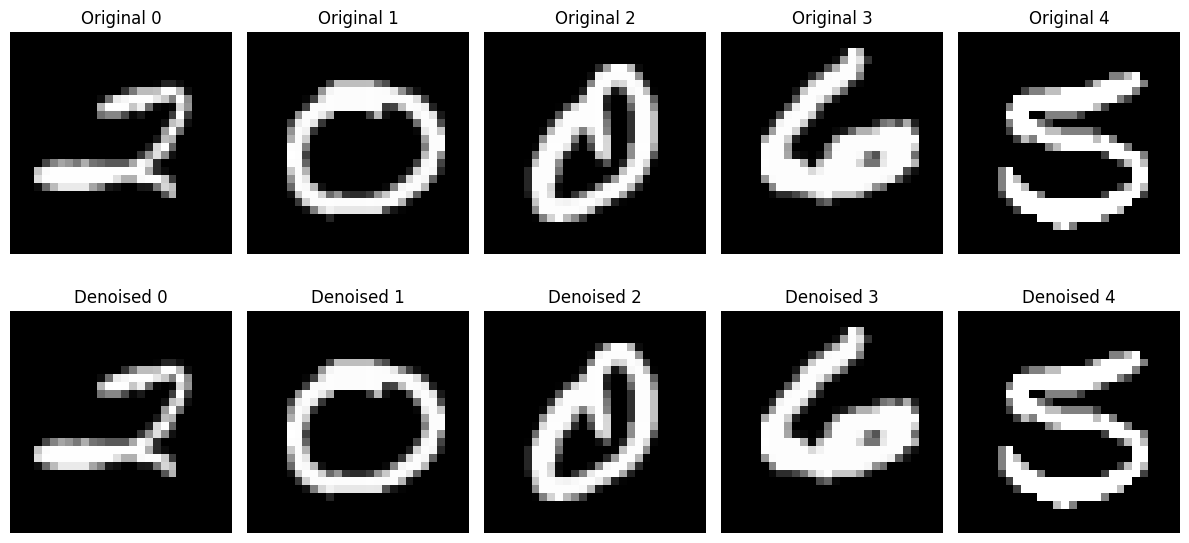

In [2]:
# Apply Gaussian filtering to reduce noise
X_denoised = np.zeros_like(X_images, dtype=np.float32)
for i in range(X_images.shape[0]):
    X_denoised[i] = gaussian_filter(X_images[i], sigma=0.1)

# Visualize before and after denoising
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_images[i], cmap='gray')
    plt.title(f'Original {i}')
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(X_denoised[i], cmap='gray')
    plt.title(f'Denoised {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
# Flatten the images for processing
X_flat = X_denoised.reshape(X_denoised.shape[0], -1)

# Standardize the pixel values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Apply PCA with whitening for additional noise suppression
pca = PCA(n_components=10, whiten=True, random_state=42)  # Keep components explaining 95% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced dimensions: {X_pca.shape[1]} (original: {X_flat.shape[1]})")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")


Reduced dimensions: 10 (original: 784)
Explained variance: 0.2767


K=7, Silhouette Score: 0.0074
K=8, Silhouette Score: -0.0047
K=9, Silhouette Score: -0.0320
K=10, Silhouette Score: 0.0031
K=11, Silhouette Score: -0.0103


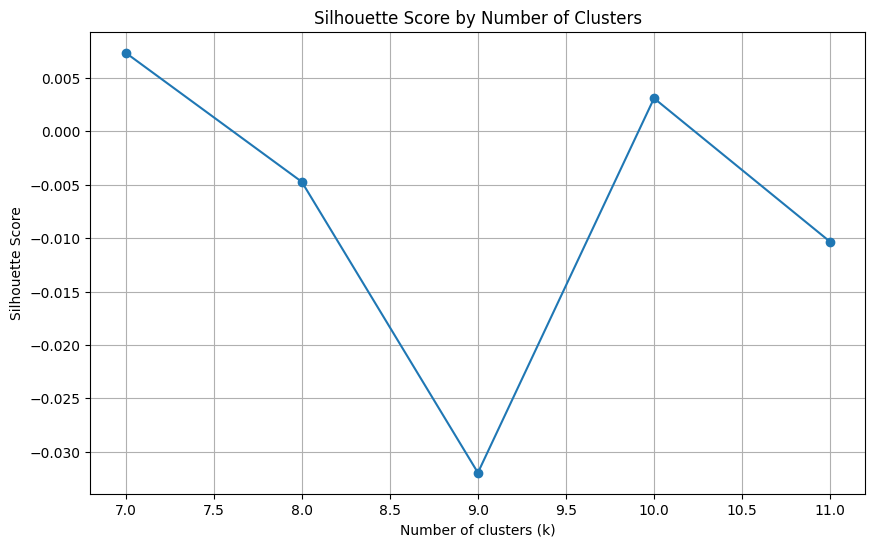

Optimal number of clusters: 7


In [4]:
# Find optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(7, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True)
plt.show()

# Select optimal k (choose k with highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")


In [4]:
# Apply K-means with optimal parameters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(X_pca)

# Count samples in each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for i, count in enumerate(counts):
    print(f"Cluster {i}: {count} images ({count/len(cluster_labels)*100:.2f}%)")


Cluster 0: 6916 images (11.53%)
Cluster 1: 8575 images (14.29%)
Cluster 2: 10561 images (17.60%)
Cluster 3: 5692 images (9.49%)
Cluster 4: 9683 images (16.14%)
Cluster 5: 4214 images (7.02%)
Cluster 6: 3477 images (5.79%)
Cluster 7: 3338 images (5.56%)
Cluster 8: 1789 images (2.98%)
Cluster 9: 5755 images (9.59%)


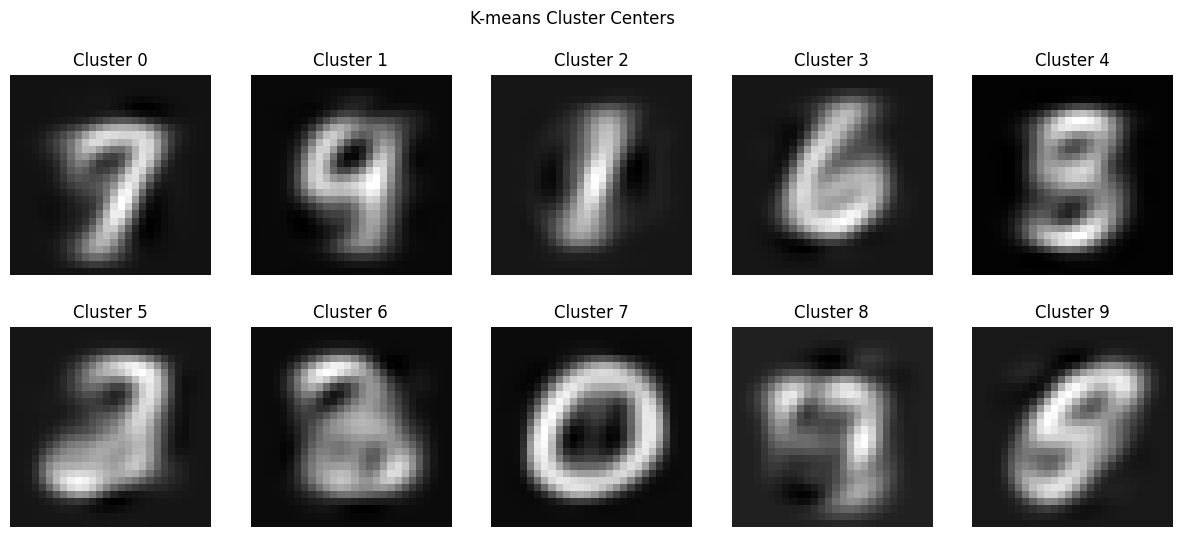

In [8]:
# Transform cluster centers back to image space
centers_pca = kmeans.cluster_centers_
centers_original = pca.inverse_transform(centers_pca)
centers_original = scaler.inverse_transform(centers_original)
centers_images = centers_original.reshape(10, 28, 28)

# Visualize the cluster centers
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, (10+1)//2, i+1)
    plt.imshow(centers_images[i], cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.suptitle('K-means Cluster Centers')
plt.show()


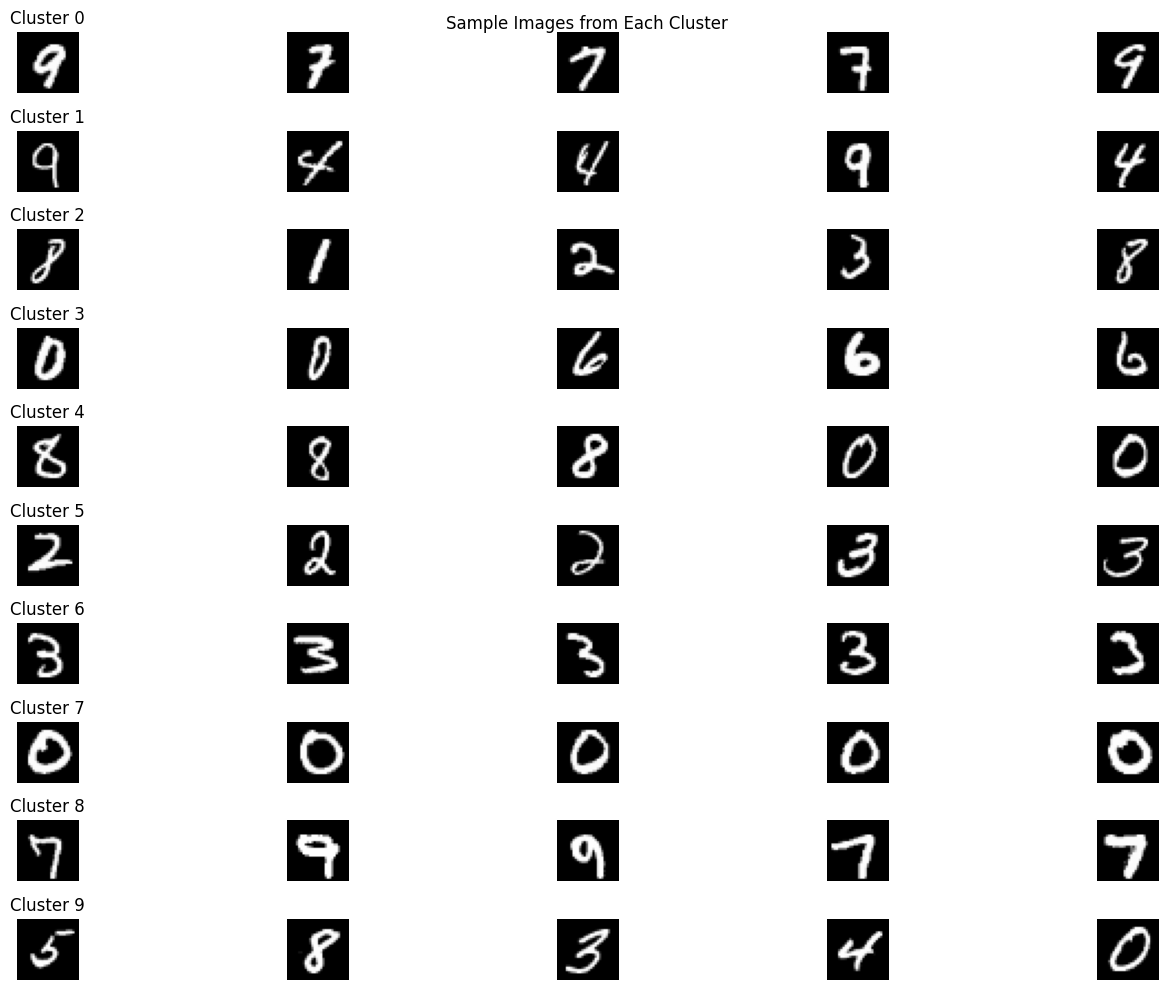

In [9]:
# Visualize sample images from each cluster
plt.figure(figsize=(15, 10))
for i in range(10):
    # Get indices of images in this cluster
    cluster_indices = np.where(cluster_labels == i)[0]
    
    # Select 5 random samples from this cluster
    if len(cluster_indices) >= 5:
        sample_indices = np.random.choice(cluster_indices, 5, replace=False)
    else:
        sample_indices = cluster_indices
    
    # Display the samples
    for j, idx in enumerate(sample_indices):
        plt.subplot(10, 5, i*5 + j + 1)
        plt.imshow(X_images[idx], cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title(f'Cluster {i}')
plt.tight_layout()
plt.suptitle('Sample Images from Each Cluster')
plt.show()


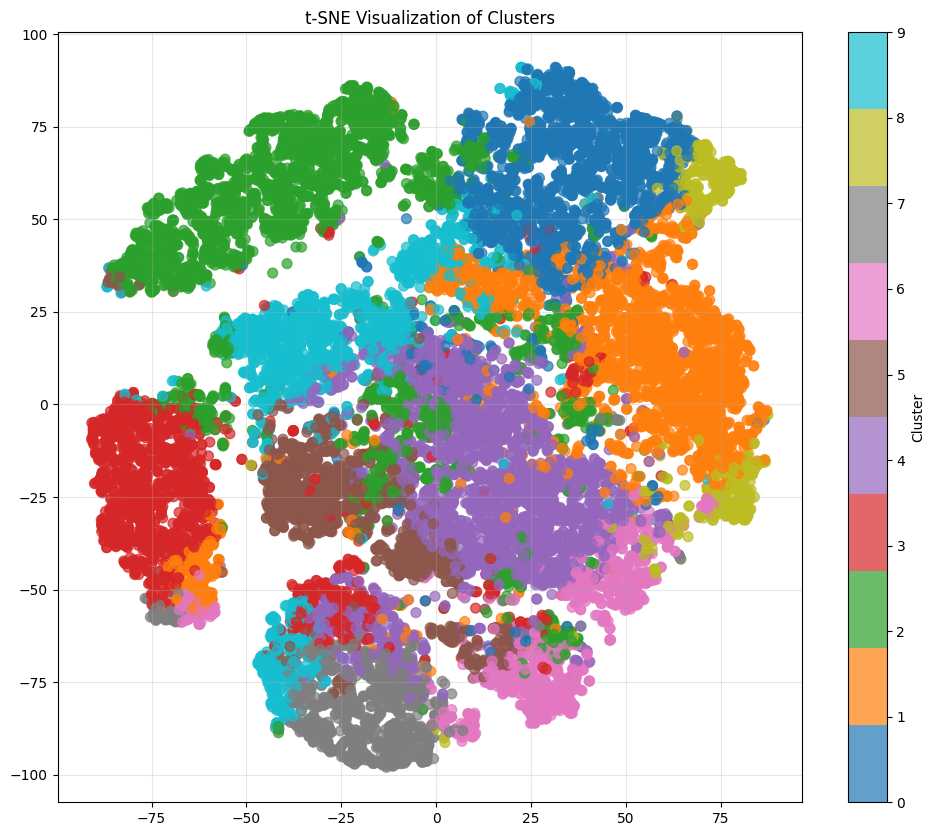

In [10]:
# Dimensionality reduction for visualization (t-SNE)
from sklearn.manifold import TSNE

# Use a subset of data for faster computation
n_samples = 20000
indices = np.random.choice(X_pca.shape[0], n_samples, replace=False)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca[indices])

# Plot t-SNE visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=cluster_labels[indices], 
                     cmap='tab10', 
                     s=50, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.grid(True, alpha=0.3)
plt.show()
